# Анализ влияния фотографий товаров на успешность продаж

Цель проекта — разработать прототип модели, которая оценивает, насколько изображение товара связано с его успешностью на маркетплейсе. Модель должна помочь понять, играют ли визуальные характеристики ключевую роль в привлечении покупателей и повышении интереса к продукту

План работы:

- Загрузка и предварительная обработка данных

- Подготовка и отбор табличных признаков

- Формирование бинарного таргета успешности товара на основании синтетической прокси метрики (топ 20%)

- Извлечение визуальных признаков из изображений

- Обучение и сравнение моделей на разных наборах признаков: Табличные, Визуальные, Комбинированные

- Анализ качества

- кластеризация изображений

Датасет используемый в проекте: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset

## Установки и импорты

In [1]:
!python.exe -m pip install --upgrade pip
!pip install kagglehub numpy pandas scikit-learn matplotlib seaborn lightgbm category_encoders 
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://download.pytorch.org/whl/cu128
  Cloning https://github.com/openai/CLIP.git to c:\users\psimera\appdata\local\temp\pip-req-build-9ncb5axm
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\PSImera\AppData\Local\Temp\pip-req-build-9ncb5axm'


In [ ]:
import os
from pathlib import Path
import shutil
import kagglehub
import random
import json
import requests
from tqdm import tqdm
from PIL import Image
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import clip

import warnings
warnings.filterwarnings('ignore')

# Добавим библиотеки для отрисовки графиков
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('dark_background')

# добавим необходимые библиотеки для построения моделей
from lightgbm import LGBMClassifier
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Сделаем небольшие настройки pandas для комфортного отображения проекта
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

d:\My_Code\bogdanov_tz\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Скачиваем датасет

In [3]:
# cache_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

In [4]:
# переместил из стандартного пути скачивания kagglehub на другой диск
DATASET_DIR = Path("D:\\My_Code\\_Datasets\\fashion-dataset") 

JSON_DIR = DATASET_DIR / 'styles'
STYLES = DATASET_DIR / 'styles.csv'
IMAGES_DIR = DATASET_DIR / 'images'
IMAGES = DATASET_DIR / 'images.csv'

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


## Осмотр и очистка датасета

In [5]:
ds = pd.read_csv(STYLES, on_bad_lines='skip')

display(ds.info())
display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


None

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0000,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0000,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0000,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0000,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0000,Casual,Puma Men Grey T-shirt


Данные в CSV не полные:
- во первых без пропуска строк с ошибками `on_bad_lines='skip'` фаил вообще не читался, а следовательно не все строки считались
- во вторых присутствует значительное количество пропусков в разных столбцах

Соберём датасет из данных по файлам json и посмотрим что там, прежде чем решать что делать с пропусками 

Ручной просмотр рандомного файла json в датасете, показывает что все те же данные, что и в csv есть и там и даже больше, возможно там данные считаются более полно

In [ ]:
records = []
for file in JSON_DIR.glob("*.json"):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        dict_to_add = {i: data["data"].get(i) for i in [
            'id', 'price', 'discountedPrice', 'brandName', 'myntraRating', 'ageGroup', 'fashionType',
            'year', 'gender', 'baseColour', 'season', 'usage', 'productDisplayName'
        ]}
        
        dict_to_add['articleType'] = data["data"]["articleType"].get('typeName')
        dict_to_add['masterCategory'] = data["data"]["masterCategory"].get('typeName')
        dict_to_add['subCategory'] = data["data"]["subCategory"].get('typeName')

        style_options = data["data"].get("styleOptions", [])
        dict_to_add['size_availability'] = len([opt for opt in style_options if opt.get('available', False)]) / (len(style_options) + 1e-6)

        other_flags = data["data"].get("otherFlags", [])
        for flag in other_flags:
            name = flag.get("name")
            value = flag.get("value", "false")
            dict_to_add[name] = 1 if value == "true" else 0
        
        records.append(dict_to_add)
        
df_json = pd.DataFrame(records)

display(df_json.info())
display(df_json.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    44446 non-null  int64  
 1   price                 44446 non-null  float64
 2   discountedPrice       44446 non-null  float64
 3   brandName             44446 non-null  object 
 4   myntraRating          44446 non-null  int64  
 5   ageGroup              44446 non-null  object 
 6   fashionType           44446 non-null  object 
 7   year                  44446 non-null  object 
 8   gender                44446 non-null  object 
 9   baseColour            44446 non-null  object 
 10  season                44446 non-null  object 
 11  usage                 44446 non-null  object 
 12  productDisplayName    44446 non-null  object 
 13  articleType           44446 non-null  object 
 14  masterCategory        44446 non-null  object 
 15  subCategory        

None

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
0,10000,649.0000,324.0000,Palm Tree,1,Kids-Girls,Fashion,2011,Women,White,Summer,Casual,Palm Tree Girls Sp Jace Sko White Skirts,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
1,10001,549.0000,274.0000,Palm Tree,1,Kids-Girls,Fashion,2011,Women,Blue,Summer,Casual,Palm Tree Kids Girls Sp Jema Skt Blue Skirts,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
2,10002,549.0000,274.0000,Palm Tree,1,Kids-Girls,Fashion,2011,Women,Blue,Summer,Casual,Palm Tree Kids Sp Jema Skt Blue Skirts,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
3,10003,2695.0000,2695.0000,Nike,1,Adults-Women,Fashion,2011,Women,White,Fall,Sports,Nike Women As Nike Eleme White T-Shirt,Tshirts,Apparel,Topwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
4,10004,1995.0000,1995.0000,Nike,1,Adults-Men,Fashion,2011,Men,Grey,Fall,Sports,Nike Men As 7 Sw Temp Grey Shorts,Shorts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1


Как видим данных считано больше. Нужно убедится что те данные, которые есть, совпадают и на местах пропусков не стоят заглушки.

Для начала поверхностно посмотрим на категориальные признаки

In [7]:
print('количество категорий в столбце brandName', len(df_json['brandName'].unique()))
print(df_json['brandName'].unique()[:10])

print('количество категорий в столбце fashionType', len(df_json['fashionType'].unique()))
print(df_json['fashionType'].unique()[:10])

print('количество категорий в столбце baseColour', len(df_json['baseColour'].unique()))
print(df_json['baseColour'].unique()[:10])

print('количество категорий в столбце usage', len(df_json['usage'].unique()))
print(df_json['usage'].unique()[:10])

print('количество категорий в столбце articleType', len(df_json['articleType'].unique()))
print(df_json['articleType'].unique()[:10])

print('количество категорий в столбце masterCategory', len(df_json['masterCategory'].unique()))
print(df_json['masterCategory'].unique()[:10])

print('количество категорий в столбце subCategory', len(df_json['subCategory'].unique()))
print(df_json['subCategory'].unique()[:10])

количество категорий в столбце brandName 424
['Palm Tree' 'Nike' 'LOCOMOTIVE' 'Reebok' 'Puma' 'Gini and Jony' 'ADIDAS'
 'Fastrack' 'Rockport' 'ESPRIT']
количество категорий в столбце fashionType 3
['Fashion' 'Core' '']
количество категорий в столбце baseColour 47
['White' 'Blue' 'Grey' 'Black' 'Navy Blue' 'Red' 'Grey Melange' 'Yellow'
 'Pink' 'Brown']
количество категорий в столбце usage 10
['Casual' 'Sports' 'Formal' 'Smart Casual' 'Ethnic' 'Travel' 'NA' 'Party'
 '' 'Home']
количество категорий в столбце articleType 143
['Skirts' 'Tshirts' 'Shorts' 'Track Pants' 'Caps' 'Dresses' 'Jackets'
 'Sweatshirts' 'Sports Shoes' 'Shirts']
количество категорий в столбце masterCategory 7
['Apparel' 'Accessories' 'Footwear' 'Free Items' 'Sporting Goods'
 'Personal Care' 'Home']
количество категорий в столбце subCategory 45
['Bottomwear' 'Topwear' 'Headwear' 'Dress' 'Shoes' 'Sandal' 'Flip Flops'
 'Watches' 'Bags' 'Belts']


проблемные места на первый взгляд:
- fashionType: пустые строки
- usage: 'NA' и пустые строки
- возможно и в других категориях они есть т.к. в некоторых признаках категорий много и выводились не все

Следует заменить их на None для удобства сравнения

In [8]:
df_json = df_json.replace(['', 'NA'], None)

Приведём колонку `year` к единому типу данных, так как сейчас в одном датасете это `float` а в другом `object`

In [9]:
ds['year'] = ds['year'].fillna(0).astype(int)
df_json['year'] = df_json['year'].fillna(0).astype(int)

In [10]:
def check_dataset_completeness(main_ds: pd.DataFrame, second_ds: pd.DataFrame, key: str = 'id', main_name: str ='main', second_name: str = 'second'):
    print("=== Проверка датасетов ===")
    
    common_cols = set(main_ds.columns) & set(second_ds.columns)

    print(f"- Общих колонок: {len(common_cols)}")
    if set(main_ds.columns) - common_cols:
        print(f"- Уникальных только в {main_name}: {set(main_ds.columns) - common_cols}")
    if set(second_ds.columns) - common_cols:
        print(f"- Уникальных только в {second_name}: {set(second_ds.columns) - common_cols}")

    missing_in_second = main_ds[~main_ds[key].isin(second_ds[key])]
    if len(missing_in_second):
        print(f"- Количество строк в {main_name}, которых нет в {second_name}: {len(missing_in_second)}")

    extra_in_second = second_ds[~second_ds[key].isin(main_ds[key])]
    if len(extra_in_second):
        print(f"- Количество строк в {second_name}, которых нет в {main_name}: {len(extra_in_second)}")

    merged = main_ds.merge(second_ds, on=key, how='left', suffixes=(f'_{main_name}', f'_{second_name}'))
    print("\n=== Различия по общим колонкам ===")
    for col in common_cols - {key}:
        diff = merged[merged[f'{col}_{main_name}'] != merged[f'{col}_{second_name}']]
        if len(diff):
            print(f"- {col}: {len(diff)} различий")

    cols_no_key = list(common_cols - {key})
    main_part = merged[[f"{col}_{main_name}" for col in cols_no_key]].fillna('')
    second_part = merged[[f"{col}_{second_name}" for col in cols_no_key]].fillna('')
    match_rate = (main_part.values == second_part.values).all(axis=1).mean() * 100
    print(f"\n=== Итог ===\nСовпадение по общим колонкам (кроме ключа): {match_rate:.2f}%")

check_dataset_completeness(ds, df_json, key='id', main_name='ds', second_name='df_json')

=== Проверка датасетов ===
- Общих колонок: 10
- Уникальных только в df_json: {'isHazmat', 'codEnabled', 'pickupEnabled', 'isLarge', 'fashionType', 'isExchangeable', 'isFragile', 'myntraRating', 'isTryAndBuyEnabled', 'isJewellery', 'discountedPrice', 'isReturnable', 'active', 'brandName', 'price', 'ageGroup', 'size_availability', 'socialSharingEnabled'}
- Количество строк в df_json, которых нет в ds: 22

=== Различия по общим колонкам ===
- baseColour: 15 различий
- season: 21 различий
- productDisplayName: 7 различий
- usage: 317 различий

=== Итог ===
Совпадение по общим колонкам (кроме ключа): 100.00%


Различия в данных по общим колонкам отсутствуют, но в `json` датасете больше признаков и больше строк из-за того что данные из csv читались с ошибками.

Будем полагатся полностью на датасет считанный напрямую из `json` файлов

# Работа с пропусками

Начнём с `fashionType`, посмотрим на строки с пропусками для начала

In [11]:
df_json[(df_json['fashionType'].isna())]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
30146,46570,9995.0000,9995.0000,Timex,0,Adults-Men,None,2017,Men,Grey,Summer,Casual,Timex Men Grey Ruthenium Intelligent Quartz An...,Watches,Accessories,Watches,0.0000,0,1,0,0,1,1,1,1,1,0,1
35819,53781,1299.0000,1299.0000,Puma,0,Adults-Men,None,0,Men,Blue,None,Sports,Puma Men Blue Sless Round Neck T-shirt,Tshirts,Apparel,Topwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
39076,57698,755.0000,566.0000,Lotus Herbals,0,Adults-Women,None,2017,Women,None,Spring,Casual,Lotus Herbals Quincenourish Quince Seed Nouris...,Face Moisturisers,Personal Care,Skin,1.0000,0,0,1,0,0,0,1,1,1,0,1


Всего три строки, просто удалим их дабы убрать шумы, тем более в одной из строк ещё и `baseColour` тоже с пропуском. Необходимо сразу проверить пропуски и там

In [12]:
df_json[df_json['baseColour'].isna()]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
1024,11288,1695.0000,1017.0000,Wrangler,0,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Blue Texas Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
1029,11293,2195.0000,1097.0000,Wrangler,0,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Blue Texas Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
1043,11309,2495.0000,1372.0000,Wrangler,1,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Blue Floyd Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
17824,30991,6600.0000,6600.0000,Issey Miyake,0,Adults-Women,Fashion,2017,Women,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
17825,30992,5500.0000,5500.0000,Issey Miyake,0,Adults-Men,Fashion,2017,Men,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
25933,41347,2195.0000,1317.0000,Wrangler,0,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Black Texas Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
25941,41355,2295.0000,2295.0000,Wrangler,0,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Blue Millard Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
25943,41357,2395.0000,2395.0000,Wrangler,1,Adults-Men,Fashion,2016,Men,None,Fall,Casual,Wrangler Men Blue Millard Jeans,Jeans,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1
27232,43116,2990.0000,1794.0000,GUESS,0,Adults-Women,Core,2017,Women,None,Spring,None,GUESS Seductive Women EDT Spray,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
27233,43119,2990.0000,1943.0000,GUESS,0,Adults-Men,Core,2017,Men,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1


Тут видно что пропуски присутствуют и в других столбцах, но ещё заметно что цвет можно взять из столбца `productDisplayName`

Но для начала посмотрим пропуски в `productDisplayName`. Много ли их? 

Вероятно что как и в этих примерах там где нет названия и в других строках пропуски

In [13]:
df_json[df_json['productDisplayName'].isna()]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
17824,30991,6600.0000,6600.0000,Issey Miyake,0,Adults-Women,Fashion,2017,Women,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
17825,30992,5500.0000,5500.0000,Issey Miyake,0,Adults-Men,Fashion,2017,Men,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
26992,42863,3699.0000,3699.0000,French Connection,1,Adults-Women,Fashion,2012,Women,Brown,Summer,Casual,None,Clutches,Accessories,Bags,0.0000,0,1,0,0,1,1,1,1,1,0,1
27007,42878,3699.0000,3699.0000,French Connection,1,Adults-Women,Fashion,2012,Women,Maroon,Summer,Casual,None,Clutches,Accessories,Bags,0.0000,0,1,0,0,1,1,1,1,1,0,1
27233,43119,2990.0000,1943.0000,GUESS,0,Adults-Men,Core,2017,Men,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
29408,45687,0.0000,0.0000,TOUS,0,Adults-Men,Core,2017,Men,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1
29414,45698,0.0000,0.0000,DAVID BECKHAM,0,Adults-Women,Fashion,2017,Women,None,Spring,None,None,Perfume and Body Mist,Personal Care,Fragrance,0.0000,0,0,1,0,0,0,1,1,1,0,1


Да, так и есть, сразу избавимся от этих 7 строк и посмотрим далее

In [14]:
df_json = df_json[~(df_json['productDisplayName'].isna())]
df_json[df_json['usage'].isna()]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
2046,12447,290.0000,290.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Brown,Fall,None,Timberland Unisex Brown Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
2047,12448,590.0000,590.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Tan,Fall,None,Timberland Unisex Tan Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
2048,12449,590.0000,590.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Brown,Fall,None,Timberland Unisex Brown Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
2049,12450,90.0000,90.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Brown,Fall,None,Timberland Unisex Brown Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
2050,12451,390.0000,390.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,White,Fall,None,Timberland Unisex White Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41760,6840,440.0000,440.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Brown,Summer,None,Timberland Unisex Dry Cleaning Shoe Kit,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
41761,6841,640.0000,640.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Black,Summer,None,Timberland Unisex Foam Cleaner Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
41764,6844,190.0000,190.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Brown,Summer,None,Timberland Unisex Boot Lace Shoe Accessories,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1
43521,8915,390.0000,390.0000,Timberland,0,Adults-Unisex,Fashion,2011,Unisex,Black,Fall,None,Timberland Unisex Black Boot Sauce Cream,Shoe Accessories,Accessories,Shoe Accessories,0.0000,0,0,1,0,0,0,1,1,1,0,1


Достаточно много. Смотря на эти строки сделаем допущение что использование предметов одежды `Casual`, `Sports`, `Formal` и т.д. связано с брендами. посмотрим на отдельно взятый бренд

In [15]:
df_json[df_json['brandName'] == 'Timberland']['usage'].value_counts()

usage
Casual    228
Sports      2
Name: count, dtype: int64

Допущение можно сказать подтверждается, по крайней мере на этом бренде, все кроме двух товаров имеют категорию `Casual`

Исходя из того, что строк с пропусками не значительное количество и бренды как правило фокусируются на одной нише будь то спорт или повседневная одежда, то ошибки определения таким способом если и будут, то их будет слишком мало, чтобы испортить нам статистику. В случае массового количества пропусков, такой подход был бы возможно критичным и стоило бы думать над поиском других вариантов его решения, вплоть до ручной разметки данных

Ну а я решил заполнить значения `Usage` по наиболее часто встречающемуся значению для отдельно взятого бренда в данном кейсе

In [16]:
for brand, group in df_json.groupby('brandName'):
    most_common = group.loc[~group['usage'].isna(), 'usage'].mode()
    if not most_common.empty:
        df_json.loc[(df_json['brandName'] == brand) & (df_json['usage'].isna()), 'usage'] = most_common.iloc[0]

Исправим цвета взяв их из названия если есть, а если нет, то удалим эти строки

In [17]:
colors = sorted([c for c in df_json["baseColour"].unique() if c], key=len, reverse=True)

to_drop = []
for i, row in df_json[df_json["baseColour"].isna()].iterrows():
    if row["productDisplayName"] is not None:
        found = False
        for color in colors:
            if color in row["productDisplayName"]:
                df_json.at[i, "baseColour"] = color
                found = True
                break
        if not found:
            to_drop.append(i)

df_json = df_json.drop(index=to_drop)

Проверим что ещё осталось из пропусков

In [18]:
df_json[df_json.isna().any(axis=1)]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
15716,28319,0.0000,0.0000,Red Tape,0,None,Fashion,2018,Men,Brown,Winter,Casual,RTV_LoadTest,Sandals,Footwear,Sandal,0.0000,0,1,0,0,1,1,1,0,1,0,1
30146,46570,9995.0000,9995.0000,Timex,0,Adults-Men,None,2017,Men,Grey,Summer,Casual,Timex Men Grey Ruthenium Intelligent Quartz An...,Watches,Accessories,Watches,0.0000,0,1,0,0,1,1,1,1,1,0,1
35602,5354,1199.0000,1199.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Men,Grey,None,Sports,Kalenji Ekiden 50 Wht/grey 09,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35611,5355,2299.0000,2299.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Men,Grey,None,Sports,Kalenji Kapteren 100 Grey/white,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35662,5360,2299.0000,2299.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Women,Grey,None,Sports,Kalenji Kapteren 100 Blue/grey,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35672,5361,1499.0000,1499.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Men,Black,None,Sports,Kipsta F300 Fg Sr Ah09,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35708,5365,2999.0000,2999.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Unisex,Green,None,Sports,Solognac Shoes Namib 200,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35737,5368,4999.0000,4999.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Men,Red,None,Sports,Kalenji Kiprun 1000 White Red Ss10,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35753,5370,4499.0000,4499.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Men,Black,None,Sports,Inesis Canaveral 700 Black,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1
35796,5376,4999.0000,4999.0000,Decathlon,0,Adults-Unisex,Fashion,2011,Unisex,Black,None,Sports,Btwin Mtb Shoes 7,Sports Shoes,Footwear,Shoes,0.0000,0,1,0,0,1,1,1,1,1,0,1


Там где `year` == 0 и `fashionType`, это всего одна строка - её удалим сразу, потому что сразу в двух столбцах пропуск.
Остальные заполним наиболее частыми значениями

In [19]:
df_json = df_json[df_json['year'] != 0]

mode_fashion = df_json.loc[~df_json['fashionType'].isna(), 'fashionType'].mode()[0]
df_json.loc[df_json['fashionType'].isna(), 'fashionType'] = mode_fashion

mode_season = df_json.loc[~df_json['season'].isna(), 'season'].mode()[0]
df_json.loc[df_json['season'].isna(), 'season'] = mode_season

In [20]:
df_json[df_json['ageGroup'].isna()]

,id,price,discountedPrice,brandName,myntraRating,ageGroup,fashionType,year,gender,baseColour,season,usage,productDisplayName,articleType,masterCategory,subCategory,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
15716,28319,0.0000,0.0000,Red Tape,0,None,Fashion,2018,Men,Brown,Winter,Casual,RTV_LoadTest,Sandals,Footwear,Sandal,0.0000,0,1,0,0,1,1,1,0,1,0,1


Есть всего одно значение в возрастной группе с пропуском. Если бы значений было много, то стоило бы придумать какой-то алгоритм (самые частые для данного гендара например), но так как оно всего одно, то на данный момент проще его из интуитивного предположения что это за возрастная группа заменить.

Кроме того в поле гендера разделение не тольо по признаку пола, но и по возрасту, а в поле возраста ещё и по полу. Это сразу тоже исправим

In [21]:
print(df_json['gender'].unique())
print(df_json['ageGroup'].unique())
print(df_json['gender'].value_counts())
print(df_json['ageGroup'].value_counts())

['Women' 'Men' 'Unisex' 'Boys' 'Girls']
['Kids-Girls' 'Adults-Women' 'Adults-Men' 'Adults-Unisex' 'Kids-Boys'
 'Kids-Unisex' None]
gender
Men       22159
Women     18627
Unisex     2164
Boys        830
Girls       655
Name: count, dtype: int64
ageGroup
Adults-Men       21881
Adults-Women     18421
Adults-Unisex     1942
Kids-Boys         1071
Kids-Girls         849
Kids-Unisex        270
Name: count, dtype: int64


In [22]:
df_json['ageGroup'] = df_json['ageGroup'].fillna('adults').map({
    'Adults-Men': 'adults',
    'Adults-Women': 'adults',
    'Adults-Unisex': 'adults',
    'Kids-Boys': 'kids',
    'Kids-Girls': 'kids',
    'Kids-Unisex': 'kids'
})

df_json['gender'] = df_json['gender'].fillna('unisex').map({
    'Men': 'man',
    'Women': 'woman',
    'Boys': 'man',
    'Girls': 'woman',
    'Unisex': 'unisex'
})

Создадим параметры длинны названия и количества слов в нём и удалим колонку productDisplayName

In [23]:
print(df_json.columns.tolist())

['id', 'price', 'discountedPrice', 'brandName', 'myntraRating', 'ageGroup', 'fashionType', 'year', 'gender', 'baseColour', 'season', 'usage', 'productDisplayName', 'articleType', 'masterCategory', 'subCategory', 'size_availability', 'isFragile', 'isTryAndBuyEnabled', 'isHazmat', 'isJewellery', 'isReturnable', 'isExchangeable', 'active', 'socialSharingEnabled', 'pickupEnabled', 'isLarge', 'codEnabled']


In [24]:
df_json['name_length'] = df_json['productDisplayName'].str.len()
df_json['name_word_count'] = df_json['productDisplayName'].str.split().str.len()
df_json.drop('productDisplayName', axis=1, inplace=True)

`price` и `discountedPrice` не выглядят как два полезных параметра, они скорее просто будут коррелировать между собой и пользы от этого мало. Лучше убрать цену со скидкой и заменить её на процент скидки. Тоже сразу это сделаем, а так же переименуем столбцы и датасет для удобства

In [25]:
df_json = df_json[~((df_json['price'] == 0) | (df_json['discountedPrice'] == 0))]

df_json['discountedPrice'] = 1 - df_json['discountedPrice'] / df_json['price']

ds = df_json.rename(columns={
    'discountedPrice': 'discount_rate',
    'brandName': 'brand',
    'myntraRating': 'rating',
    'ageGroup': 'age',
    'fashionType': 'fashion_type',
    'baseColour': 'color',
    'articleType': 'article_type',
    'masterCategory': 'category',
    'subCategory': 'sub_category'
    })

Проверим остались ли пропуски

In [26]:
ds[ds.isna().any(axis=1)]

,id,price,discount_rate,brand,rating,age,fashion_type,year,gender,color,season,usage,article_type,category,sub_category,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled,name_length,name_word_count


In [27]:
brand_counts = ds['brand'].value_counts()
ds['brand_popularity'] = ds['brand'].map(brand_counts)

## Проверим наличие изображений для всех записей

Взглянем на изображения

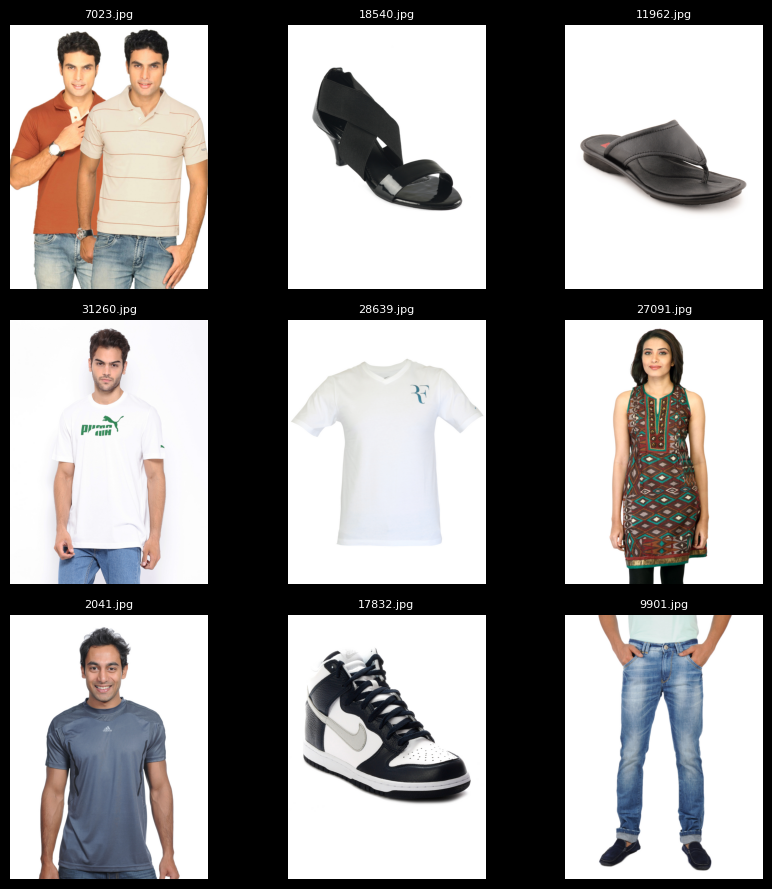

In [ ]:
images = [f for f in os.listdir(IMAGES_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

images_sample = random.sample(images, 9)
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ax, img_file in zip(axes.flatten(), images_sample):
    img = mpimg.imread(os.path.join(IMAGES_DIR, img_file))
    ax.imshow(img)
    ax.set_title(img_file, fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [28]:
images = pd.read_csv(IMAGES, on_bad_lines='skip')
display(images.info())
display(images.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  44446 non-null  object
 1   link      44446 non-null  object
dtypes: object(2)
memory usage: 694.6+ KB


None

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


Похоже что названия файлов это их id с добавлением расширения файлов. проверим это далее и если это так, то эта информация у нас уже есть

In [29]:
folder_files = {f.name for f in IMAGES_DIR.iterdir() if f.is_file()}
dataset_files = {f"{str(i)}.jpg" for i in ds['id']}

missing = dataset_files - folder_files
extra = folder_files - dataset_files

print(f"Всего файлов в папке: {len(folder_files)}")
print(f"Всего файлов по датасету: {len(dataset_files)}")
print(f"Файлов, которых нет в папке: {len(missing)}")
print(f"Лишних файлов в папке: {len(extra)}")

Всего файлов в папке: 44441
Всего файлов по датасету: 44433
Файлов, которых нет в папке: 5
Лишних файлов в папке: 13


Id из датасета совпадают с именами файлов, но пять ихображений не найдены. Попробуем скачать их по ссылкам

In [30]:
for f in missing:
    img_row = images[images['filename'] == f]
    if img_row.empty:
        print(f"Ссылка для {f} не найдена в датасете images")
        continue
    
    url = img_row.iloc[0]['link']
    img_path = IMAGES_DIR / f

    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
        with open(img_path, 'wb') as f:
            for chunk in response.iter_content(1024):
                f.write(chunk)
    except Exception as e:
        print(f"Ошибка при загрузке {f}: {e}")


Ошибка при загрузке 12347.jpg: Invalid URL 'undefined': No scheme supplied. Perhaps you meant https://undefined?
Ошибка при загрузке 39410.jpg: Invalid URL 'undefined': No scheme supplied. Perhaps you meant https://undefined?
Ошибка при загрузке 39403.jpg: Invalid URL 'undefined': No scheme supplied. Perhaps you meant https://undefined?
Ошибка при загрузке 39401.jpg: Invalid URL 'undefined': No scheme supplied. Perhaps you meant https://undefined?
Ошибка при загрузке 39425.jpg: Invalid URL 'undefined': No scheme supplied. Perhaps you meant https://undefined?


Не получается, ссылки не находятся в датасете. проверим как много таких ссылок во всём датасете

In [31]:
undefined_rows = images[images['link'] == 'undefined']
print(f"Количество строк с undefined ссылкой: {len(undefined_rows)}")
print(undefined_rows)

Количество строк с undefined ссылкой: 5
        filename       link
6697   39403.jpg  undefined
16207  39410.jpg  undefined
32324  39401.jpg  undefined
36399  39425.jpg  undefined
40022  12347.jpg  undefined


Как раз те 5 изображений. Видимо проще просто удалить строки для которых изображений нет. и так как это последее удаление строк, сбросим индексы

In [32]:
ds = ds[~ds['id'].isin([int(f.replace('.jpg', '')) for f in missing])]
ds = ds.reset_index(drop=True)

display(ds.info())
display(ds.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44428 entries, 0 to 44427
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    44428 non-null  int64  
 1   price                 44428 non-null  float64
 2   discount_rate         44428 non-null  float64
 3   brand                 44428 non-null  object 
 4   rating                44428 non-null  int64  
 5   age                   44428 non-null  object 
 6   fashion_type          44428 non-null  object 
 7   year                  44428 non-null  int64  
 8   gender                44428 non-null  object 
 9   color                 44428 non-null  object 
 10  season                44428 non-null  object 
 11  usage                 44428 non-null  object 
 12  article_type          44428 non-null  object 
 13  category              44428 non-null  object 
 14  sub_category          44428 non-null  object 
 15  size_availability  

None

,id,price,discount_rate,brand,rating,age,fashion_type,year,gender,color,season,usage,article_type,category,sub_category,size_availability,isFragile,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled,name_length,name_word_count,brand_popularity
0,10000,649.0000,0.5008,Palm Tree,1,kids,Fashion,2011,woman,White,Summer,Casual,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1,40,8,110
1,10001,549.0000,0.5009,Palm Tree,1,kids,Fashion,2011,woman,Blue,Summer,Casual,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1,44,9,110
2,10002,549.0000,0.5009,Palm Tree,1,kids,Fashion,2011,woman,Blue,Summer,Casual,Skirts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1,38,8,110
3,10003,2695.0000,0.0000,Nike,1,adults,Fashion,2011,woman,White,Fall,Sports,Tshirts,Apparel,Topwear,0.0000,0,1,0,0,1,1,1,1,1,0,1,38,7,2203
4,10004,1995.0000,0.0000,Nike,1,adults,Fashion,2011,man,Grey,Fall,Sports,Shorts,Apparel,Bottomwear,0.0000,0,1,0,0,1,1,1,1,1,0,1,33,8,2203


# Создадим прокси метрику и target на её основании

In [33]:
category_weights = {'Apparel': 1.0, 'Accessories': 0.8, 'Footwear': 0.7, 'Personal Care': 0.5, 'Free Items': 0.1, 'Sporting Goods': 0.05, 'Home': 0.01}
season_weights = {'Summer': 1.0, 'Fall': 0.9, 'Winter': 0.8, 'Spring': 0.7}
gender_weights = {'woman': 1.0, 'unisex': 0.9, 'man': 0.7}
age_weights = {'adults': 1.0, 'kids': 0.8}

scaler = MinMaxScaler()
features_to_normalize = ['rating', 'discount_rate', 'size_availability', 'brand_popularity']
normalized = scaler.fit_transform(ds[features_to_normalize])

def calculate_success_score(row):
    i = row.name
    score = 0.0
    score += np.random.normal(0.5, 0.2)
    score += category_weights.get(row.get('category', ''), 0.5)
    score += season_weights.get(row.get('season', ''), 0.5)
    score += gender_weights.get(row.get('gender', ''), 0.7)
    score += age_weights.get(row.get('age', ''), 0.5)
    score += min(row.get('name_length', '') / 100, 0.3)
    score += min(row.get('name_word_count', '') / 100, 0.2)
    score += normalized[i, 0] * 0.80
    score += normalized[i, 1] * 0.10
    score += normalized[i, 2] * 0.05
    score += normalized[i, 3] * 0.05
    score += np.random.normal(0, 0.1)
    return max(0, score)

ds['success_score'] = ds.apply(calculate_success_score, axis=1)

success_threshold = ds['success_score'].quantile(0.8)
ds['target'] = (ds['success_score'] >= success_threshold).astype(int)

print(f"\nПорог для топ-20%: {success_threshold:.3f}")
print(ds['target'].value_counts())

print(f"\nТоп-5 самых успешных товаров:")
top_products = ds.nlargest(5, 'success_score')[['brand', 'category', 'sub_category', 'rating', 'price', 'discount_rate', 'size_availability', 'success_score']]
print(top_products.to_string(index=False))

ds = ds.drop(['brand_popularity', 'success_score'], axis=1)


Порог для топ-20%: 4.794
target
0    35542
1     8886
Name: count, dtype: int64

Топ-5 самых успешных товаров:
           brand    category sub_category  rating     price  discount_rate  size_availability  success_score
            Puma     Apparel      Topwear      10 1799.0000         0.0000             0.0000         5.8412
        Geonaute Accessories         Bags      10 1199.0000         0.0000             0.0000         5.7910
          Reebok     Apparel      Topwear      10 2499.0000         0.0000             0.0000         5.7516
      Jealous 21     Apparel      Topwear       1  799.0000         0.0000             0.0000         5.6857
Allen Solly Kids     Apparel      Topwear       0  499.0000         0.0000             0.0000         5.6703


# Считаем эмбединги изображений

In [34]:
def extract_clip_embeddings(ds, images_folder):
    print("Загружаем модель CLIP...")
    model, preprocess = clip.load("ViT-B/32", device=device)
    model.eval()
    
    embeddings_list = []
    successful_count = 0
    failed_count = 0
    
    print(f"Начинаем обработку {len(ds)} изображений...")
    for _, row in tqdm(ds.iterrows(), total=len(ds), desc="Извлекаем эмбеддинги"):
        image_id = row['id']
        image_path = images_folder / f"{image_id}.jpg"
        
        try:
            # Проверяем существование файла
            if not image_path.exists():
                print(f"Изображение не найдено: {image_path}")
                embeddings_list.append(None)
                failed_count += 1
                continue
            
            # Загружаем и предобрабатываем изображение
            image = Image.open(image_path).convert('RGB')
            image_input = preprocess(image).unsqueeze(0).to(device)
            
            # Извлекаем эмбеддинги без вычисления градиентов
            with torch.no_grad():
                image_features = model.encode_image(image_input)
                # Нормализуем эмбеддинги
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                # Конвертируем в numpy
                embedding = image_features.cpu().numpy().flatten()
            
            embeddings_list.append(embedding)
            successful_count += 1
            
        except Exception as e:
            print(f"Ошибка при обработке {image_path}: {str(e)}")
            embeddings_list.append(None)
            failed_count += 1
    
    # Добавляем эмбеддинги в датасет
    print(f"len(ds) = {len(ds)}, len(embeddings_list) = {len(embeddings_list)}")

    ds_copy = ds.copy()
    ds_copy['embeddings'] = embeddings_list
    
    print(f"\nОбработка завершена!")
    print(f"Успешно обработано: {successful_count} изображений")
    print(f"Не удалось обработать: {failed_count} изображений")
    
    return ds_copy

def expand_embeddings(data):
    """
    Универсальная функция для разворачивания эмбеддингов.
    Работает с DataFrame (ищет столбец 'embeddings') или с Series (содержащей эмбеддинги).
    """
    if isinstance(data, pd.Series):
        print('Разворачивваем Эмбединг из Series')
        series_type = True
        embeddings_series = data.copy()
    elif isinstance(data, pd.DataFrame):
        print('Разворачивваем Эмбединг из колонки embeddings датасета')
        series_type = False
        if 'embeddings' not in data.columns:
            raise ValueError("DataFrame должен содержать столбец 'embeddings'")
        embeddings_series = data['embeddings']
    else:
        raise TypeError("Входные данные должны быть pandas.DataFrame или pandas.Series")
        
    valid_mask = embeddings_series.notna()
    if valid_mask.sum() == 0:
        print('Все значения пустые')
        return data
    
    embedding_dim = len(embeddings_series.loc[valid_mask].iloc[0])
    print(f'Размер эмбединга = {embedding_dim}')
    
    # Создаем и заполняем матрицу для всех эмбеддингов
    embeddings_matrix = np.zeros((len(embeddings_series), embedding_dim))
    for idx, embedding in enumerate(embeddings_series):
        if embedding is not None:
            embeddings_matrix[idx] = embedding
        else:
            print(f'Пустое поле: {idx}')
            embeddings_matrix[idx] = np.zeros(embedding_dim)
    
    # Создаем DataFrame с эмбеддингами
    embedding_columns = [f'embedding_{i}' for i in range(embedding_dim)]
    embeddings_df = pd.DataFrame(embeddings_matrix, 
                            columns=embedding_columns,
                            index=data.index)
    
    if series_type:
        return embeddings_df
    return pd.concat([data.drop('embeddings', axis=1), embeddings_df], axis=1)

def save_ds_with_emb(ds, filepath):
    ds_save = ds.copy()
    ds_save['embeddings'] = ds_save['embeddings'].apply(lambda x: ','.join(map(str, x)) if x is not None else None)
    ds_save.to_csv(filepath, index=False)
    print(f"Датасет сохранен: {filepath}")

def load_ds_with_emb(filepath):
    ds_load = pd.read_csv(filepath)
    ds_load['embeddings'] = ds_load['embeddings'].apply(lambda x: np.array([float(i) for i in x.split(',')]) if pd.notna(x) else None)
    print(f"Датасет загружен: {filepath}")
    return ds_load

In [35]:
EMB_FROM_RESERV = False
EMB_RESERV_PATH = 'models/dataset_with_embadings.csv'

if EMB_FROM_RESERV:
    ds = load_ds_with_emb(EMB_RESERV_PATH)
else:
    ds = extract_clip_embeddings(ds, IMAGES_DIR)
    save_ds_with_emb(ds, EMB_RESERV_PATH)

Загружаем модель CLIP...
Начинаем обработку 44428 изображений...


Извлекаем эмбеддинги: 100%|██████████| 44428/44428 [50:38<00:00, 14.62it/s]  


len(ds) = 44428, len(embeddings_list) = 44428

Обработка завершена!
Успешно обработано: 44428 изображений
Не удалось обработать: 0 изображений
Датасет сохранен: models/dataset_with_embadings.csv


# Подготовка датасета к обучению

Разобьём датасет на тренировочную и тестовую выборки

In [38]:
X = ds.drop(['target', 'id'], axis=1)
y = ds['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=SEED
)

print('Размер тренировочной выборки:')
print(f'признаки {X_train.shape};')
print(f'целевой признак {y_train.shape}')
print(f'это {round((y_train.count() / y.count()) * 100)}% от датасета')
print()
print('Размер тестовой выборки:')
print(f'признаки {X_test.shape};')
print(f'целевой признак {y_test.shape}')
print(f'это {round((y_test.count() / y.count()) * 100)}% от датасета')

Размер тренировочной выборки:
признаки (33321, 29);
целевой признак (33321,)
это 75% от датасета

Размер тестовой выборки:
признаки (11107, 29);
целевой признак (11107,)
это 25% от датасета


Закодируцем категориальные признаки с помощью Label Encoder

In [40]:
categorical_features = [
    'brand', 'age', 'fashion_type', 'gender', 'color', 'season',
    'usage', 'article_type', 'category', 'sub_category'
]

encoder = TargetEncoder(cols=categorical_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)
joblib.dump(encoder, f'models/TargetEncoder.pkl')

['models/TargetEncoder.pkl']

Выделим два дополнительных набора фичей с только эмбедингами и с только табличными данными

In [41]:
X_tab_train = X_train.drop(['embeddings'], axis=1)
X_emb_train = expand_embeddings(X_train['embeddings'])

X_tab_test = X_test.drop(['embeddings'], axis=1)
X_emb_test = expand_embeddings(X_test['embeddings'])

X_train = expand_embeddings(X_train)
X_test = expand_embeddings(X_test)

Разворачивваем Эмбединг из Series
Размер эмбединга = 512
Разворачивваем Эмбединг из Series
Размер эмбединга = 512
Разворачивваем Эмбединг из колонки embeddings датасета
Размер эмбединга = 512
Разворачивваем Эмбединг из колонки embeddings датасета
Размер эмбединга = 512


Создадим дополнительные объекты и функции, необходимые далее

In [50]:
# Датафрейм для сохранения результатов
results = pd.DataFrame(columns=['Модель',
                                'лучшая ROC-AUC метрика',
                                'F1 метрика при лучшей ROC-AUC',
                                'лучшая F1 метрика',
                                'ROC-AUC метрика при лучшей F1'])

X_var = {'FullData': X_train,
         'TabData': X_tab_train,
         'Embbadings': X_emb_train
         }

X_test_var = {'FullData': X_test,
         'TabData':X_tab_test,
         'Embbadings': X_emb_test
         }

params = {}

# KFold кроссвалидация
cv = KFold(n_splits=5, random_state=SEED, shuffle=True)

# метрики
scoring = ['roc_auc', 'f1']

lgbm_parameters = {'n_estimators': range(100, 1001, 100),
                   'max_depth': [-1, 0, 1, 4, 8, 12, 16],
                   'num_leaves': range(20, 51),
                   'learning_rate': np.linspace(0.01, 0.2, 20),
                   'verbose': [-1]
                   }

# Функция для вывода метрик на экран и сохранения их в общую таблицу результатов
def sch_scores(prefix, full_model_name, n):
    # Загружаем объект поиска
    search_obj = eval(prefix + '_sch')
    cv_results = search_obj.cv_results_

    # Достаём метрики ROC-AUC, F1, F1 при лучшем ROC-AUC и ROC-AUC при лучшем F1
    best_roc_auc = cv_results['mean_test_roc_auc'][np.where(cv_results['rank_test_roc_auc'] == 1)[0][0]]
    best_f1 = cv_results['mean_test_f1'][np.where(cv_results['rank_test_f1'] == 1)[0][0]]
    f1_per_roc_auc = cv_results['mean_test_f1'][np.where(cv_results['mean_test_roc_auc'] == best_roc_auc)[0][0]]
    roc_auc_per_f1 = cv_results['mean_test_roc_auc'][np.where(cv_results['mean_test_f1'] == best_f1)[0][0]]

    # Делаем глобальные переменные
    globals()[f'{prefix}_best_roc_auc'] = best_roc_auc
    globals()[f'{prefix}_best_f1'] = best_f1
    globals()[f'{prefix}_f1_per_roc_auc'] = f1_per_roc_auc
    globals()[f'{prefix}_roc_auc_per_f1'] = roc_auc_per_f1

    # Выводим результаты
    print(f'{full_model_name}')
    print('при параметрах: ', search_obj.best_params_)
    print('~' * 79)
    print('Наилучший показатель ROC-AUC на кросс-валидации: ', round(best_roc_auc, 4))
    print('показатель F1 при лучшем ROC-AUC: ', round(f1_per_roc_auc, 4))
    print('~' * 79)
    print('Наилучший показатель F1 на кросс-валидации: ', round(best_f1, 4))
    print('показатель ROC-AUC при лучшем F1: ', round(roc_auc_per_f1, 4))

    # Добавляем строку в таблицу результатов
    results.loc[n] = [
        full_model_name,
        best_roc_auc,
        f1_per_roc_auc,
        best_f1,
        roc_auc_per_f1
    ]
    params[full_model_name] = search_obj.best_params_
 
# функция расчета метрик ROC-AUC и построения кривой
def roc_auc_chart(model, X, y, prefix, full_model_name, size=5): 
    # Рассчитываем метрики и назначаем переменные с учётом префикса
    globals()[f'{prefix}_proba'] = model.predict_proba(X)
    globals()[f'{prefix}_proba_one'] = eval(prefix+'_proba')[:, 1]
    globals()[f'{prefix}_roc_auc'] = roc_auc_score(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_fpr'], globals()[f'{prefix}_tpr'], globals()[f'{prefix}_treshold'] = roc_curve(y, eval(prefix+'_proba_one'))
    globals()[f'{prefix}_auc_score'] = auc(eval(prefix+'_fpr'), eval(prefix+'_tpr'))

    # выводим на экран значение метрики
    print(f'{full_model_name}: ROC-AUC = ', round(eval(prefix+'_roc_auc'), 4))

    # строим график
    plt.figure(figsize=(size, size))
    plt.title(f'{full_model_name}: ROC-кривая')
    prefix_auc_score = eval(prefix+'_auc_score')
    plt.plot(eval(prefix+'_fpr'), eval(prefix + '_tpr'),
             color='darkorange',
             label=f'ROC кривая (area = {round(prefix_auc_score, 4)})')
    plt.plot([0, 1], [0, 1], color='white', linestyle='--')
    plt.xlim([-0.005, 1.005])
    plt.ylim([-0.005, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show();


Обучим модель на всех даных

In [ ]:
full_model = LGBMClassifier(random_state=SEED, objective='binary', class_weight='balanced')

full_sch = RandomizedSearchCV(full_model,
                              param_distributions=lgbm_parameters,
                              n_iter=100,
                              cv=cv,
                              scoring=scoring,
                              refit='roc_auc',
                              random_state=SEED
                              )

full_sch.fit(X_train, y_train)

FullData
при параметрах:  {'verbose': -1, 'num_leaves': 47, 'n_estimators': 700, 'max_depth': 1, 'learning_rate': np.float64(0.08)}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.8615
показатель F1 при лучшем ROC-AUC:  0.5765
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель F1 на кросс-валидации:  0.5867
показатель ROC-AUC при лучшем F1:  0.8526

FullData: ROC-AUC =  0.8708


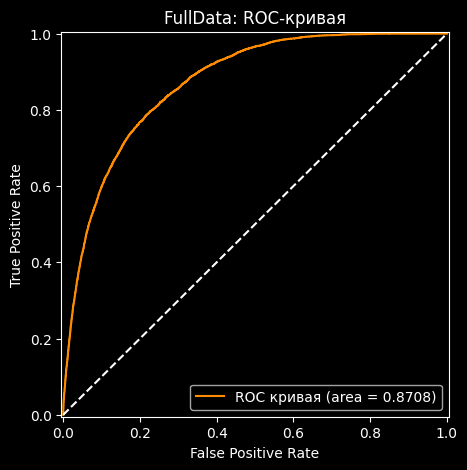

In [54]:
sch_scores('full', 'FullData', 0)
print()
roc_auc_chart(full_sch, X_train, y_train, 'full', 'FullData')

In [ ]:
tab_model = LGBMClassifier(random_state=SEED, objective='binary', class_weight='balanced')

tab_sch = RandomizedSearchCV(tab_model,
                              param_distributions=lgbm_parameters,
                              n_iter=100,
                              cv=cv,
                              scoring=scoring,
                              refit='roc_auc',
                              random_state=SEED
                              )

tab_sch.fit(X_tab_train, y_train)

TabData
при параметрах:  {'verbose': -1, 'num_leaves': 38, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': np.float64(0.14)}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.8646
показатель F1 при лучшем ROC-AUC:  0.5785
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель F1 на кросс-валидации:  0.5785
показатель ROC-AUC при лучшем F1:  0.8645

TabData: ROC-AUC =  0.8684


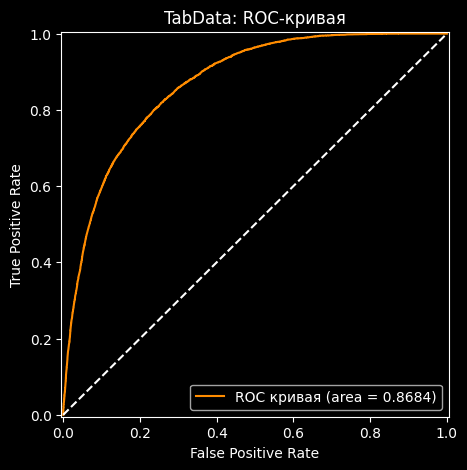

In [55]:
sch_scores('tab', 'TabData', 1)
print()
roc_auc_chart(tab_sch, X_tab_train, y_train, 'tab', 'TabData')

In [ ]:
emb_model = LGBMClassifier(random_state=SEED, objective='binary', class_weight='balanced')

emb_sch = RandomizedSearchCV(emb_model,
                              param_distributions=lgbm_parameters,
                              n_iter=100,
                              cv=cv,
                              scoring=scoring,
                              refit='roc_auc',
                              random_state=SEED
                              )

emb_sch.fit(X_emb_train, y_train)



Embbadings
при параметрах:  {'verbose': -1, 'num_leaves': 46, 'n_estimators': 300, 'max_depth': 0, 'learning_rate': np.float64(0.02)}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель ROC-AUC на кросс-валидации:  0.8213
показатель F1 при лучшем ROC-AUC:  0.5546
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Наилучший показатель F1 на кросс-валидации:  0.5594
показатель ROC-AUC при лучшем F1:  0.8195

Embbadings: ROC-AUC =  0.9331


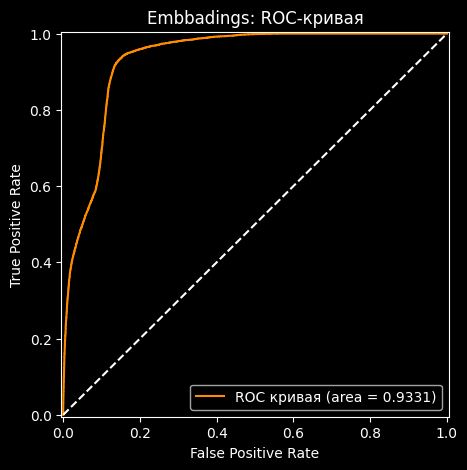

In [56]:
sch_scores('emb', 'Embbadings', 2)
print()
roc_auc_chart(emb_sch, X_emb_train, y_train, 'emb', 'Embbadings')

In [57]:
results

,Модель,лучшая ROC-AUC метрика,F1 метрика при лучшей ROC-AUC,лучшая F1 метрика,ROC-AUC метрика при лучшей F1
0,FullData,0.8615,0.5765,0.5867,0.8526
1,TabData,0.8646,0.5785,0.5785,0.8645
2,Embbadings,0.8213,0.5546,0.5594,0.8195


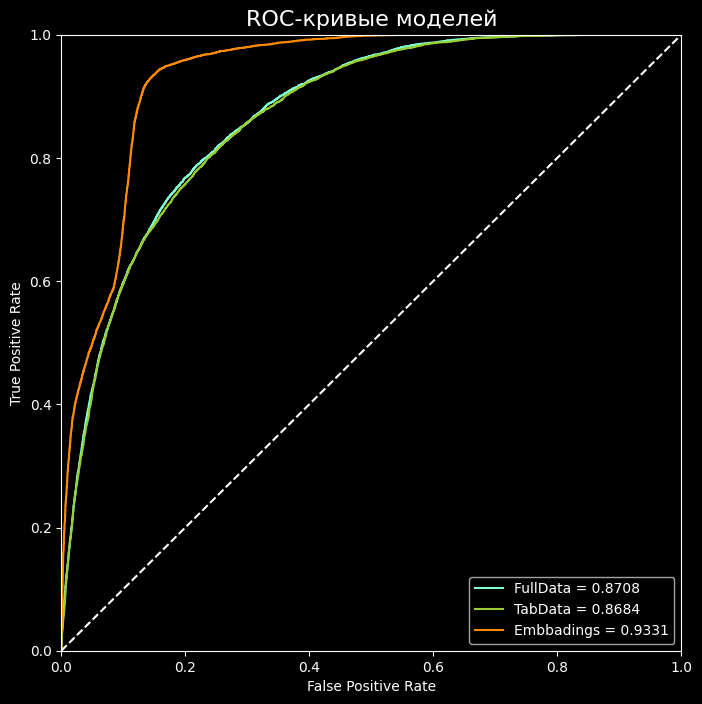

In [58]:
fig, ax = plt.subplots(figsize=(8,8))
plt.title('ROC-кривые моделей', fontsize=16)
ax.plot(full_fpr, full_tpr, color='aquamarine', label=f'FullData = {round(full_auc_score, 4)}')
ax.plot(tab_fpr, tab_tpr, color='yellowgreen', label=f'TabData = {round(tab_auc_score, 4)}')
ax.plot(emb_fpr, emb_tpr, color='darkorange', label=f'Embbadings = {round(emb_auc_score, 4)}')

plt.plot([0, 1], [0, 1], color='white', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show();

Глядя на эти результаты, можно сказать что модель с изображениями обучается хуже. Хоть не общей метрики мы видим результат заметно лучше, но на кросс-валидации она наоборот проигрывает. Это признаки того, что модель переобучилась и просто запомнила признаки. Корректней оценивать модель лучше по показателям кроссвалидации, а это модель обученная на табличных танных

## Тестирование модели

In [53]:
results

,Модель,лучшая ROC-AUC метрика,F1 метрика при лучшей ROC-AUC,лучшая F1 метрика,ROC-AUC метрика при лучшей F1


Лучшая модель: TabData
параметры: {'verbose': -1, 'num_leaves': 38, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': np.float64(0.14)} 

Test Model: ROC-AUC =  0.8654


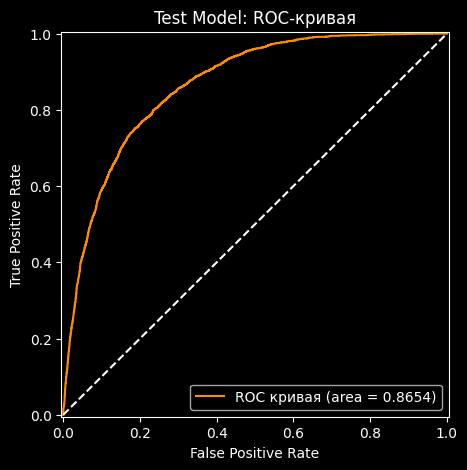

F1 лучшей модели на тестовой выборке: 0.6082


In [60]:
best_model = results.loc[results['лучшая ROC-AUC метрика'].idxmax(), 'Модель']
best_params = params[best_model]

print('Лучшая модель:', best_model)
print('параметры:', best_params, '\n')


test_model = LGBMClassifier(
    random_state=SEED,
    class_weight='balanced',
    objective='binary',
    **best_params
)

test_model.fit(X_var[best_model], y_train)

roc_auc_chart(test_model, X_test_var[best_model], y_test, 'test', 'Test Model')

best_trashold = max([[f1_score(y_test, a), t] for a, t in [(test_proba_one > t, t) for t in np.arange(0, 1.01, 0.005)]], key=lambda x: x[0])[1]
predict = test_proba_one > best_trashold
test_f1 = f1_score(y_test, predict)
print(f'F1 лучшей модели на тестовой выборке: {round(test_f1, 4)}')

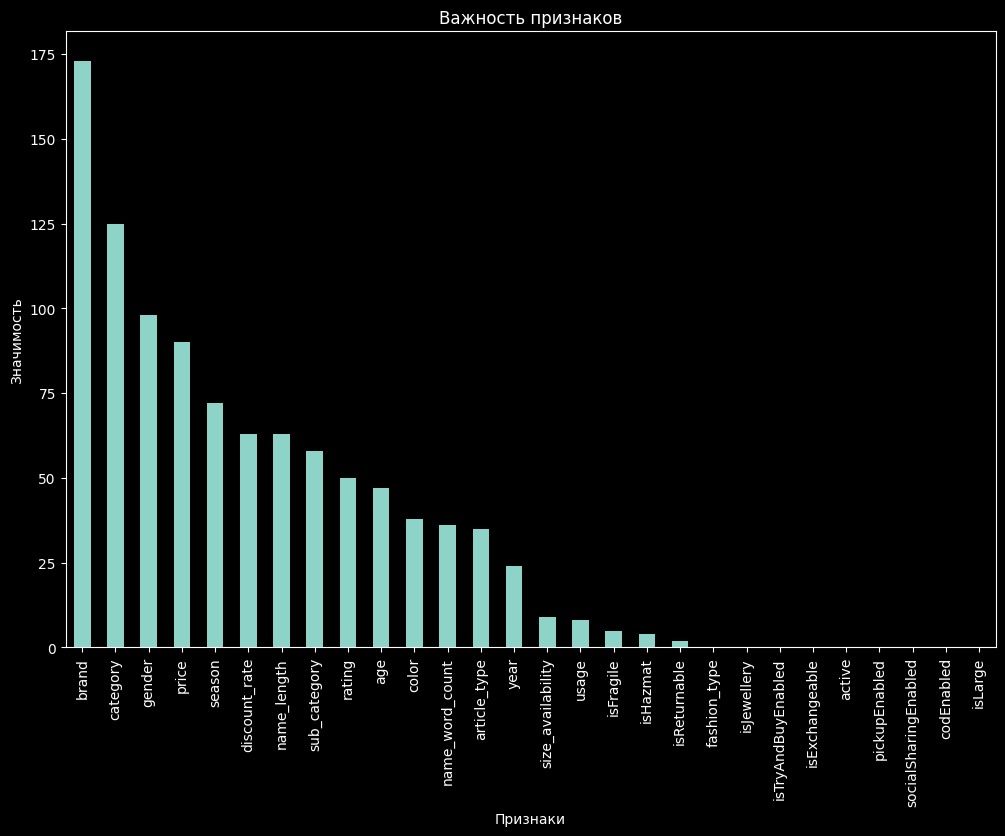

In [ ]:
importances = pd.Series(test_model.feature_importances_, index=X_test_var[best_model].columns)

fig, ax = plt.subplots(figsize=(12, 8))
importances.sort_values(ascending=False).plot.bar(ax=ax)
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Значимость')
plt.show()

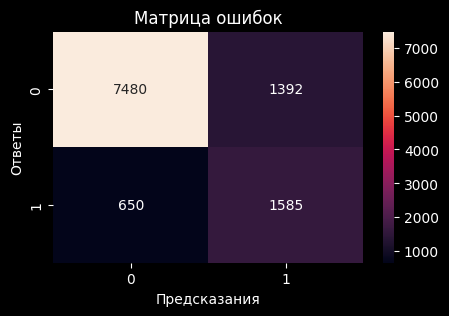

In [62]:
cmx = pd.DataFrame(confusion_matrix(y_test, predict))

plt.figure(figsize=(5,3))
plt.title('Матрица ошибок')
sns.heatmap(cmx, annot=True, fmt='d')
plt.xlabel('Предсказания')
plt.ylabel('Ответы')
plt.show()

In [63]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=SEED)
dummy_clf.fit(X_var[best_model], y_train)
dummy_predict = dummy_clf.predict(X_test)
dummy_roc_auc = roc_auc_score(dummy_predict, y_test)
dummy_f1 = f1_score(dummy_predict, y_test)

if test_roc_auc > dummy_roc_auc:
    print(f'ROC-AUC метрика нашей модели ({round(test_roc_auc, 4)}) '
    f'выше чем в модели случайного подбора параметров '
    f'({round(dummy_roc_auc, 4)}), наша модель адекватна')
else:
    print(f'ROC-AUC метрика нашей модели ({round(test_roc_auc, 4)}) '
    f'ниже чем чем в модели случайного подбора параметров '
    f'({round(dummy_roc_auc, 4)}), наша модель неадекватна')


if test_f1 > dummy_f1:
    print(f'F1 метрика нашей модели ({round(test_f1, 4)}) '
    f'выше чем в модели случайного подбора параметров '
    f'({round(dummy_f1, 4)}), наша модель адекватна')
else:
    print(f'F1 метрика нашей модели ({round(test_f1, 4)}) '
    f'ниже чем чем в модели случайного подбора параметров '
    f'({round(dummy_f1, 4)}), наша модель неадекватна')

ROC-AUC метрика нашей модели (0.8654) выше чем в модели случайного подбора параметров (0.5051), наша модель адекватна
F1 метрика нашей модели (0.6082) выше чем в модели случайного подбора параметров (0.2942), наша модель адекватна


# Кластеризация

In [67]:
k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Поиск оптимального количества кластеров...")
for k in tqdm(k_range, desc="Кластеризация"):
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    cluster_labels = kmeans.fit_predict(X_emb_train)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_emb_train, cluster_labels)
    silhouette_scores.append(sil_score)

opt_k = k_range[np.argmax(silhouette_scores)]
print(f"Оптимальное количество: {opt_k}")
final_kmeans = KMeans(n_clusters=opt_k, random_state=SEED, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_emb_train)

print(f"Распределение по кластерам: {np.bincount(cluster_labels)}")

ds_clust = ds.iloc[:len(cluster_labels)].copy()
ds_clust['visual_cluster'] = cluster_labels

cluster_analysis = ds_clust.groupby('visual_cluster').agg({
    'target': ['count', 'sum', 'mean'],
    'category': lambda x: x.mode().iloc[0],
    'gender': lambda x: x.mode().iloc[0]
}).round(3)

cluster_analysis.columns = ['Количество', 'Успешные', 'Доля_успешных', 'Топ_категория', 'Топ_пол']

print(f"\nАНАЛИЗ УСПЕШНОСТИ ПО ВИЗУАЛЬНЫМ КЛАСТЕРАМ:")
print(cluster_analysis.sort_values('Доля_успешных', ascending=False))

Поиск оптимального количества кластеров...


Кластеризация: 100%|██████████| 9/9 [02:58<00:00, 19.83s/it]


Оптимальное количество: 6
Распределение по кластерам: [5710 1905 6093 6926 5977 6710]

АНАЛИЗ УСПЕШНОСТИ ПО ВИЗУАЛЬНЫМ КЛАСТЕРАМ:
                Количество  Успешные  Доля_успешных Топ_категория Топ_пол
visual_cluster                                                           
4                     5977      1287         0.2150       Apparel     man
5                     6710      1353         0.2020       Apparel     man
0                     5710      1130         0.1980       Apparel     man
2                     6093      1181         0.1940       Apparel     man
1                     1905       366         0.1920       Apparel     man
3                     6926      1288         0.1860       Apparel     man


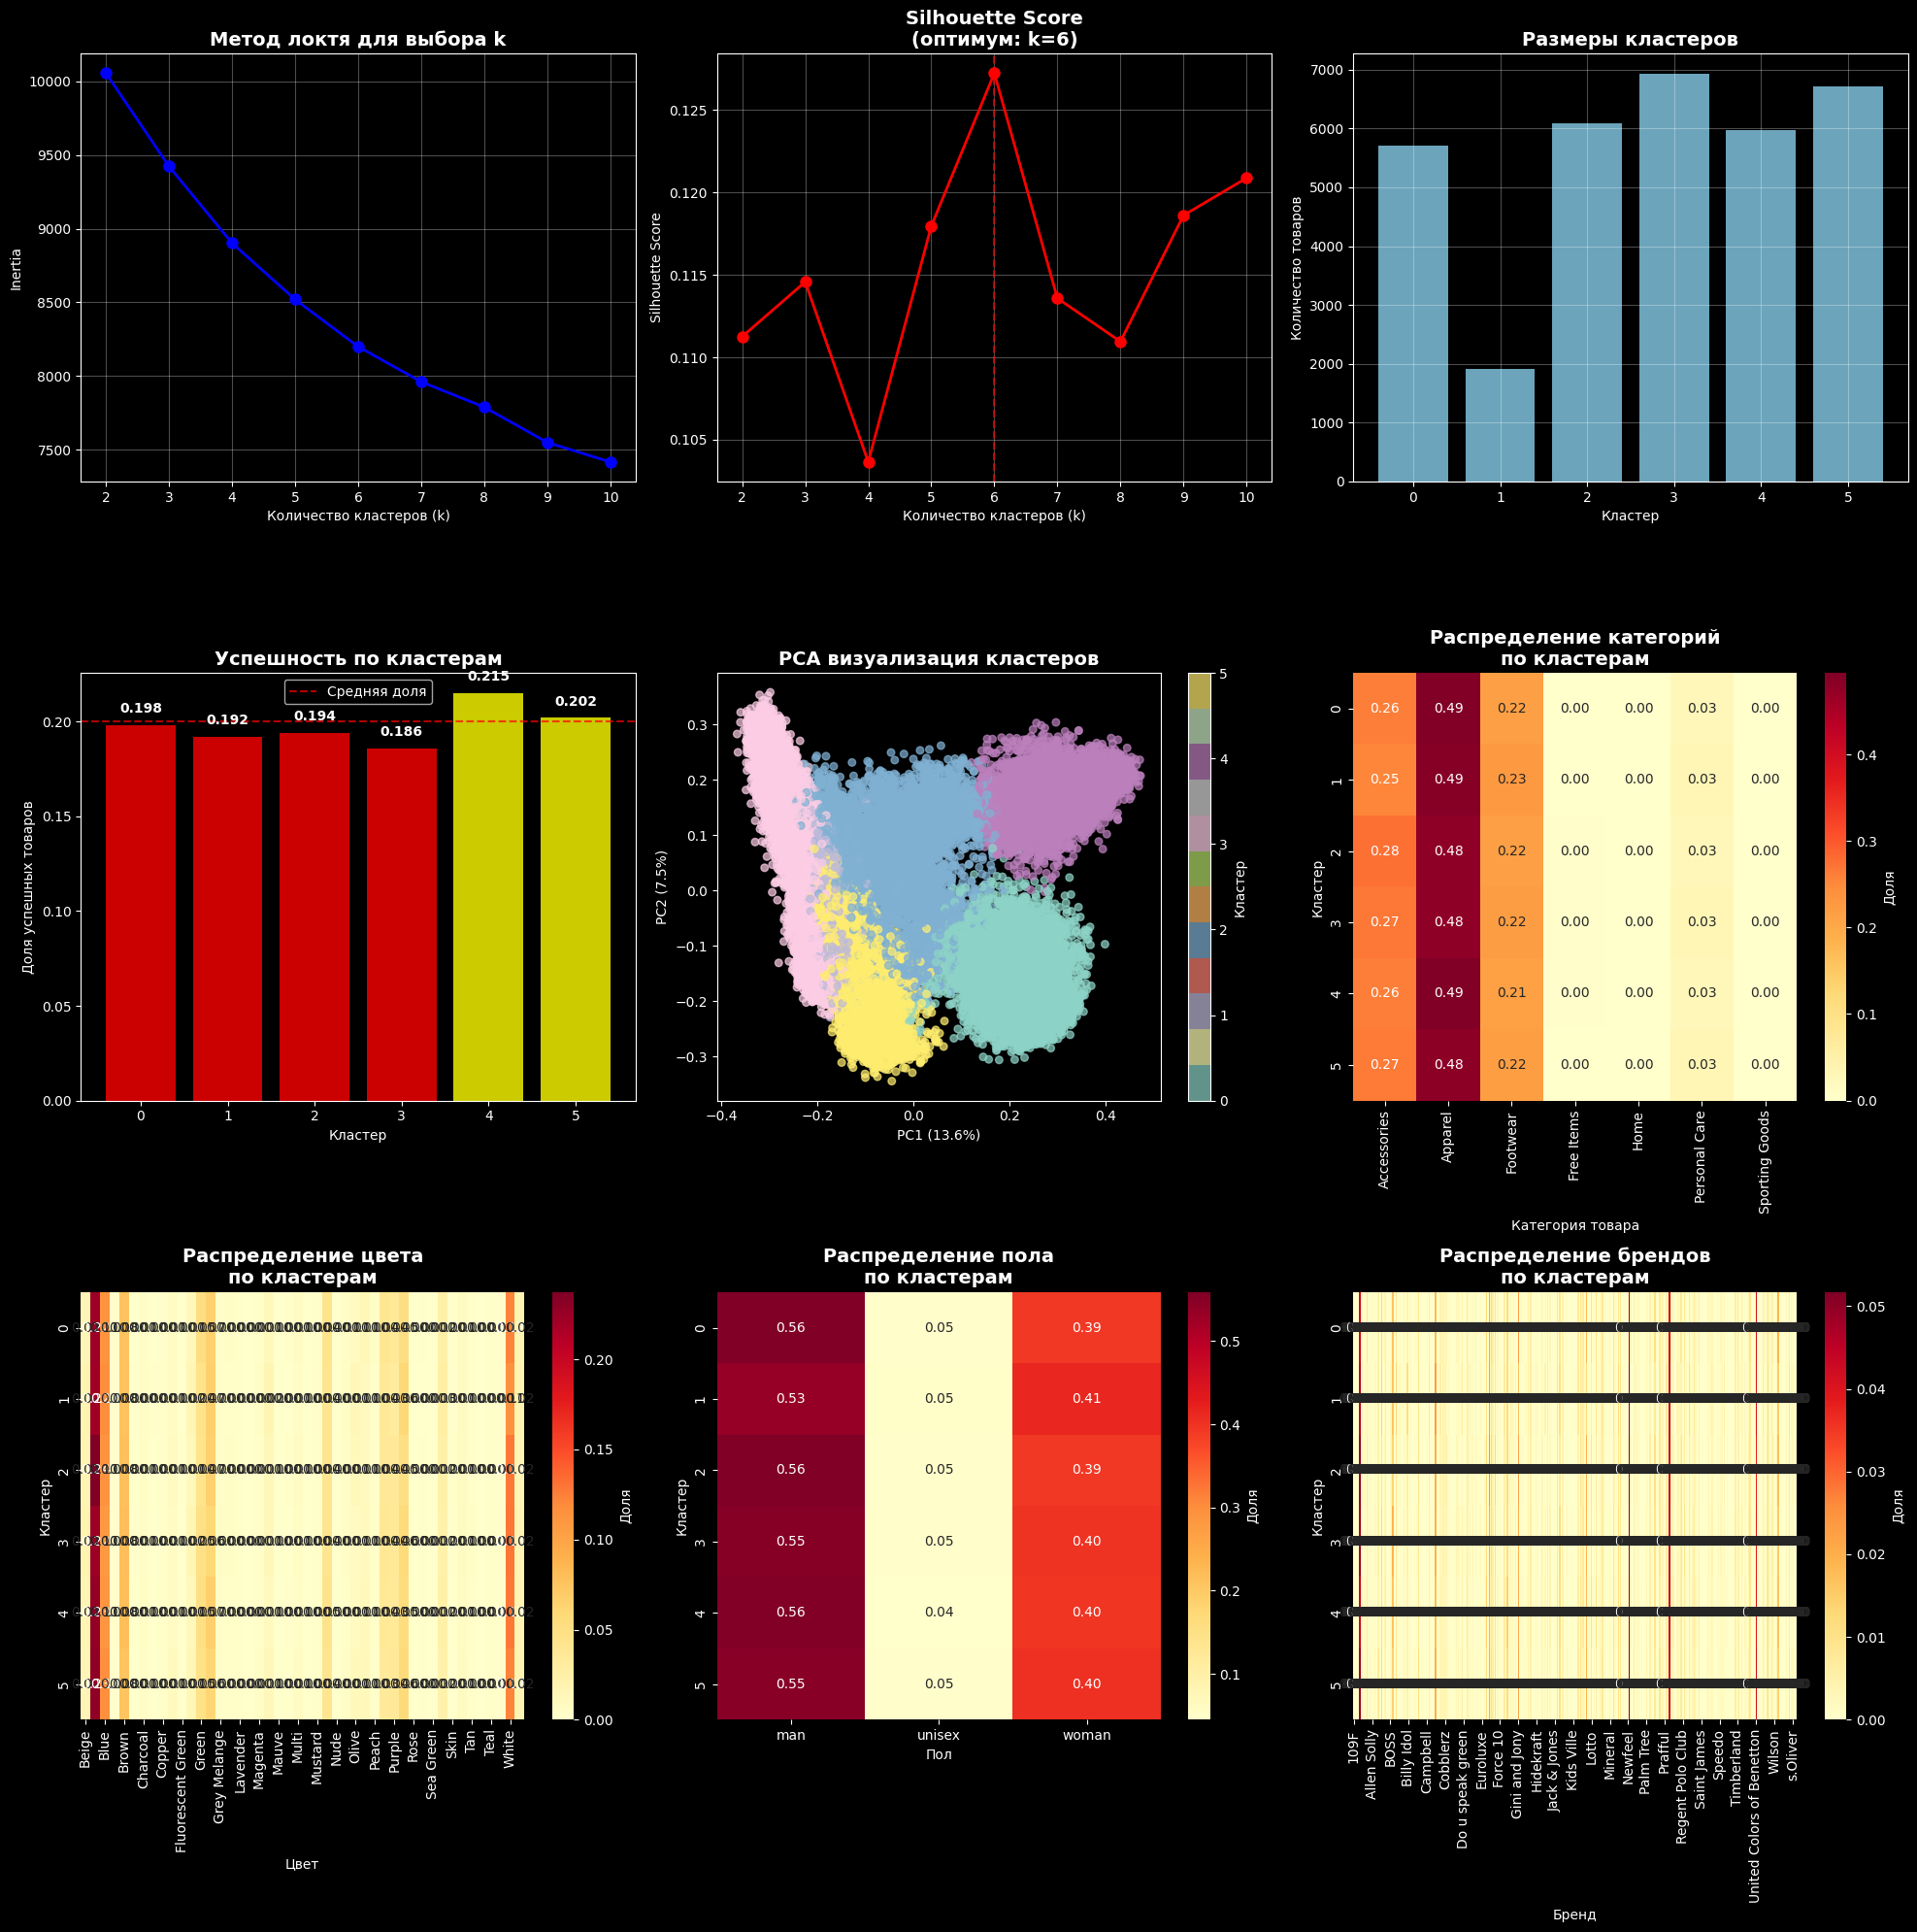

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

axes[0,0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Количество кластеров (k)')
axes[0,0].set_ylabel('Inertia')
axes[0,0].set_title('Метод локтя для выбора k', fontsize=14, fontweight='bold')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[0,1].axvline(x=opt_k, color='red', linestyle='--', alpha=0.7)
axes[0,1].set_xlabel('Количество кластеров (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].set_title(f'Silhouette Score\n(оптимум: k={opt_k})', fontsize=14, fontweight='bold')
axes[0,1].grid(True, alpha=0.3)

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
axes[0,2].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.8)
axes[0,2].set_xlabel('Кластер')
axes[0,2].set_ylabel('Количество товаров')
axes[0,2].set_title('Размеры кластеров', fontsize=14, fontweight='bold')
axes[0,2].grid(True, alpha=0.3)

success_by_cluster = cluster_analysis['Доля_успешных']
colors = ['red' if x < 0.2 else 'yellow' if x < 0.25 else 'green' for x in success_by_cluster]
bars = axes[1,0].bar(success_by_cluster.index, success_by_cluster.values, color=colors, alpha=0.8)
axes[1,0].set_xlabel('Кластер')
axes[1,0].set_ylabel('Доля успешных товаров')
axes[1,0].set_title('Успешность по кластерам', fontsize=14, fontweight='bold')
axes[1,0].axhline(y=0.2, color='red', linestyle='--', alpha=0.7, label='Средняя доля')
axes[1,0].legend()

for bar, value in zip(bars, success_by_cluster.values):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

pca_vis = PCA(n_components=2, random_state=42)
X_pca_vis = pca_vis.fit_transform(X_emb_train)
scatter = axes[1,1].scatter(X_pca_vis[:, 0], X_pca_vis[:, 1], c=cluster_labels, cmap='Set3', alpha=0.7, s=30)
axes[1,1].set_title('PCA визуализация кластеров', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel(f'PC1 ({pca_vis.explained_variance_ratio_[0]:.1%})')
axes[1,1].set_ylabel(f'PC2 ({pca_vis.explained_variance_ratio_[1]:.1%})')
cbar = plt.colorbar(scatter, ax=axes[1,1])
cbar.set_label('Кластер')

cluster_category_crosstab = pd.crosstab(ds_clust['visual_cluster'], ds_clust['category'], normalize='index')
sns.heatmap(cluster_category_crosstab, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[1,2], cbar_kws={'label': 'Доля'})
axes[1,2].set_title('Распределение категорий\nпо кластерам', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('Категория товара')
axes[1,2].set_ylabel('Кластер')

cluster_color_crosstab = pd.crosstab(ds_clust['visual_cluster'], ds_clust['color'], normalize='index')
sns.heatmap(cluster_color_crosstab, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[2,0], cbar_kws={'label': 'Доля'})
axes[2,0].set_title('Распределение цвета\nпо кластерам', fontsize=14, fontweight='bold')
axes[2,0].set_xlabel('Цвет')
axes[2,0].set_ylabel('Кластер')

cluster_gender_crosstab = pd.crosstab(ds_clust['visual_cluster'], ds_clust['gender'], normalize='index')
sns.heatmap(cluster_gender_crosstab, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[2,1], cbar_kws={'label': 'Доля'})
axes[2,1].set_title('Распределение пола\nпо кластерам', fontsize=14, fontweight='bold')
axes[2,1].set_xlabel('Пол')
axes[2,1].set_ylabel('Кластер')

cluster_brand_crosstab = pd.crosstab(ds_clust['visual_cluster'], ds_clust['brand'], normalize='index')
sns.heatmap(cluster_brand_crosstab, annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[2,2], cbar_kws={'label': 'Доля'})
axes[2,2].set_title('Распределение брендов\nпо кластерам', fontsize=14, fontweight='bold')
axes[2,2].set_xlabel('Бренд')
axes[2,2].set_ylabel('Кластер')

plt.tight_layout()
plt.show()

1. Оптимальное число кластеровМетод локтя → чёткой «точки излома» нет, инерция плавно снижается
- Silhouette Score → максимум при k = 6
- структура данных не идеально кластеризуется KMeans (силуэт низкий: ~0.12), но 6 кластеров — лучший компромисс

2. Размеры кластеров
- Кластеры получились достаточно сбалансированные: от ~1900 (кластер 1) до ~6900 (кластер 3)
- Нет явно доминирующего или крошечного кластера
- каждый кластер репрезентативен, есть смысл анализировать различия

3. Успешность по кластерам (target)
- Средняя доля успешных товаров ≈ 0.20.
- кластер 4 (0.215),
- кластер 5 (0.202).
- кластер 3 (0.186),
- кластер 1 (0.192).
- товары из кластеров 4 и 5 немного успешнее, но не на столько, чтобы можно было сказать что какие либо кластеры более успешны, соотношение такое же как и во всём датасете

4. PCA-визуализация
- На 2D-проекции видно относительно хорошо разделённые «пятна» для разных кластеров, но есть и перекрытия, что отражает невысокий силуэтный коэффициент
- данные имеют не идеально чёткие границы, но выделяются локальные плотности.

5. Распределение признаков по кластерам
- Категории равномерно распределены по всем кластерам
- Пол и Возраст тоже не выделяются в разные кластеры
- бренд тоже выглядит как заполненные вертикальные линии и не видно смысла глубоко всматриватся в этот параметр
- Небольшое преобладание голубого цвета есть во втором кластеризуется
- В целом сложно сказать что какой то из признаков может отвечать за эти кластеры

# Итоговый вывод
- Обучение модели на исключительно табличных признаках показало результаты лучше, изображения в данном случае только ухудшают результат.
Связано это с тем что мы используем синтетическую метрику, сформированную из табличных данных и никак не связанную с однотипными изображениями датасета
- Модель KMeans с k=6 выявила группы товаров
- Кластеры слабо отличающиеся по успешности (максимум +3% к "успешности")
- Silhouette score низкий
- возможно имеет смысл попробовать использовать эти кластеры как фичи, но это не входило в планы этого проекта, а так же вероятность подтверждения этой гипотезы мала
- Есть предположение что изображения в датасете очень похожи по своему типажу, все на белом фоне, только товар, нет надписей, студийных фото с красивым цветом или ярких элементом и информации на них, например про скидки. Если бы мы оценивали фото с реальных маркетплейсов и на реальных метриках CTR, то там бы влияние фото было бы заметнее
